In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import itczmip.load as imload
import itczmip.compute as imcompute
xr.set_options(keep_attrs=True)

In [2]:
fig_dir = "figures"

### Load data

In [3]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

experiment_list = [
    "itcz-SST",
    "itcz-slab",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab-4xCO2",
    "itcz-slab-4xCO2-m40",
    "itcz-slab-4xCO2-m20",
    "itcz-slab-4xCO2-p20",
    "itcz-slab-4xCO2-p40",
]

exp_ctl_list = experiment_list[1:6]
exp_4xCO2_list = experiment_list[6:11]
exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
    "response": exp_pert_list,
}

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

### Compute derived variables and metrics

In [4]:
for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

In [5]:
ds_metrics = imcompute.calc_metrics(data, model_list, experiment_list)

In [6]:
ds_metrics

<xarray.Dataset>
Dimensions:                    (model: 4, experiment: 11)
Coordinates:
  * model                      (model) <U8 'GFDL-AM2' 'CESM1' 'CESM2' 'Isca'
  * experiment                 (experiment) <U19 'itcz-SST' ... 'itcz-slab-4x...
Data variables: (12/63)
    Hadley-psi500-SH           (experiment, model) float64 -25.33 ... -25.61
    ITCZ-psi500-SH             (experiment, model) float64 -6.351 ... -8.767
    ITCZ-psi500-zero-trop      (experiment, model) float64 0.003296 ... 0.02955
    ITCZ-psi500-NH             (experiment, model) float64 6.341 7.153 ... 9.162
    ITCZ-psimax-SH             (experiment, model) float64 -7.027 ... -7.799
    ITCZ-psimax-NH             (experiment, model) float64 7.019 7.1 ... 7.798
    ...                         ...
    Hadley-psimean-area        (experiment, model) float64 -2.181e+14 ... -2....
    descent-psimean-area       (experiment, model) float64 -2.746e+14 ... -2....
    descent-psimean-extent     (experiment, model) float64 -63.36 ... -67.92
    descent-psimean-strength   (experiment, model) float64 -0.01812 ... -0.00...
    downwardmassflux-psimean   (experiment, model) float64 507.2 400.1 ... 215.3
    jetlat-ua850               (experiment, model) float64 34.4 36.52 ... 38.55

### Plot

In [7]:
# define what models to use for scatter plot
model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]
model_list_name = "_".join(model_plot_list)

# define x and y variables for scatter plot, for two subplots
plot_vars_1 = {"x": {"var": "ITCZ-psi500-extent", "exp": "control"}, "y": {"var": "Hadley-psi500-extent-half", "exp": "control"}}

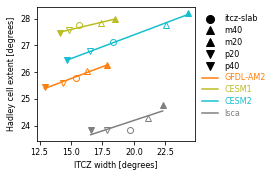

In [8]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(10*cm, 6.5*cm))
plt.subplot(111)



[x_data, y_data] = [plot_vars_1["x"], plot_vars_1["y"]]
title=''
plot_best_fit=True
plot_legend=True

symbols = {
    "itcz-SST": "x",
    "itcz-slab-m40": "^",
    "itcz-slab-m20": "^",
    "itcz-slab": "o",
    "itcz-slab-p20": "v",
    "itcz-slab-p40": "v"
}

fill_style = {
    "itcz-SST": "none",
    "itcz-slab-m40": "full",
    "itcz-slab-m20": "none",
    "itcz-slab": 'none',
    "itcz-slab-p20": "none",
    "itcz-slab-p40": "full"
}


labels = {
    "itcz-SST": "itcz-SST",
    "itcz-slab-m40": "m40",
    "itcz-slab-m20": "m20",
    "itcz-slab": "itcz-slab",
    "itcz-slab-p20": "p20",
    "itcz-slab-p40": "p40"
}

colors = {"GFDL-AM2": "tab:orange", "CESM1": "tab:olive", "CESM2-QOBS": "tab:cyan", "CESM2": "tab:cyan", "Isca": "tab:grey"}
line_styles = {"GFDL-AM2": "-", "CESM1": "-", "CESM2-QOBS": "--", "CESM2": "-", "Isca": "-"}

x_var = x_data["var"]
y_var = y_data["var"]

x_exp_list = exp_plot_lists[x_data["exp"]]
y_exp_list = exp_plot_lists[y_data["exp"]]

plt.xlabel("%s\n%s [%s]" % (x_data["exp"], ds_metrics[x_var].attrs["short_name"], ds_metrics[x_var].attrs["units"]),fontsize=8)
plt.ylabel("%s\n%s [%s]" % (y_data["exp"], ds_metrics[y_var].attrs["short_name"], ds_metrics[y_var].attrs["units"]),fontsize=8)

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )

# plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if plt.ylim()[0] < 0 and plt.ylim()[1] > 0:
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# compute and plot linear best fit
if plot_best_fit:
    cur_xlim = np.array(plt.xlim())

    #print("Slope and intercept for %s versus %s" % (x_var, y_var))
    for model in model_plot_list:
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(
            ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
            ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
        )
        #print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

        xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
        line_xlim=np.array([np.min(xdat),np.max(xdat)])
        plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

        #plt.plot(line_xlim, slope*line_xlim + intercept, '-' + "k")
#             plt.plot(xdat,ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment"),
#                      color= colors[model], linestyle="solid", zorder=0, linewidth=0.5)

        #plt.plot(cur_xlim, slope*cur_xlim + intercept, '-' + colors[model])

    plt.xlim(cur_xlim)


if plot_legend:
    # create legend items to label experiments by symbol
    leg_handles = []
    symbol_kwargs = dict(color="k", markerfacecolor="k", markersize=8, linestyle="none")
    for exp in x_exp_list:
        leg_handles.append(
            Line2D([0], [0], marker=symbols[exp], label=labels[exp],  fillstyle=fill_style[exp], **symbol_kwargs)
        )

    # create legend items to label models by color
    for model in model_plot_list:
#            leg_handles.append(Patch(color=colors[model], label=model))
        leg_handles.append(
            Line2D([0], [0], color=colors[model], label=model,  linestyle=line_styles[model])
        )

    # create legend
    leg = plt.legend(
        handles=leg_handles, fontsize=8, frameon=False, labelspacing=0.35, bbox_to_anchor=(1, 1)
    )

    # modify color of model labels to match handles
    for text in leg.get_texts():
        if text.get_text() in model_plot_list:
            text.set_color(colors[text.get_text()])


plt.tick_params(labelsize=8)

plt.xlabel('ITCZ width [degrees]',fontsize=8)
plt.ylabel('Hadley cell extent [degrees]',fontsize=8)
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "fig07.eps"))